# EA1:

*By Daniel Deutsch and José Lucas Barretto*

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from scipy.stats import norm


In [79]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2",
    'axes.labelpad': 10,
    'axes.titlepad': 10
})

## Load and process the dataset

We chose to work with NASDAQ's Composite Index series for the homework. Let's start by loading, processing, and visualizing the index's values and log-values.

In [5]:
# load and process dataset
df = pd.read_csv("datasets/NASDAQ_Index.csv", parse_dates=[0], dtype={1: np.float64}, na_values='.')
df.rename(columns={'DATE': 'date', 'NASDAQCOM': 'value'}, inplace=True)

# apply log to values
df['log_value'] = np.log(df['value'])

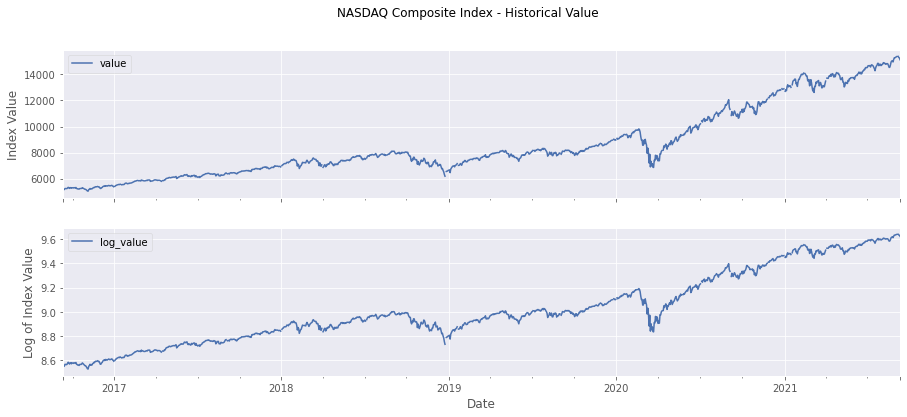

In [6]:
# plot series' values and log-values
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))

df.plot(x='date', y='value', ax=ax[0])
ax[0].set_ylabel("Index Value")

df.plot(x='date', y='log_value', ax=ax[1])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log of Index Value")

fig.suptitle("NASDAQ Composite Index - Historical Value")
plt.show()

We can see that the data has a daily frequency, and ranges from september 2016 to september 2021. We will now divide the series into two different periods. The first period ranges from september 2016 up to the start of 2019, where the series shows a relatively controlled growing behavior. The second period, which ranges from the start of 2019 until september 2021, on the other hand, contains extremely volatile periods. This will allow us to study the unpredictable behavior of stock markets, by analysing two very different behaviors of the same asset.

In [7]:
mask = df['date'] < '2019-01-01'
series1 = df[mask].dropna().reset_index(drop=True)
series2 = df[~mask].dropna().reset_index(drop=True)

## Examine whether the series are martingales or not.

We will test the hypothesis:

$$H_0:\text{The series is a martingale process.}$$

If the hypothesis is true, then:

$$ \mathbf{E}[X_{t+1}|X_t, X_{t-1}, ..., X_0] = X_t \Leftrightarrow X_{t+1} = X_t + \epsilon_{t+1}$$

Where $$\mathbf{E}[\epsilon_{t+1} | X_t, X_{t-1}, ..., X_0] = 0 $$

We can rewrite the martingale hypothesis as:

$$ X_{t+1} - X_t = \epsilon_{t+1} $$

Which allows us to test the RW3 hypothesis for the series of log prices:

$$ H_0: X_{t+1} - X_t = \mu + \epsilon_{t+1} $$

For that, we can follow the procedure described in Campbell, Lo and MacKinlay (1997, p.33).

In [122]:
def test_RW3(series, q):
    
    ac = tsa.acf(series, nlags=len(series), fft=True, adjusted=True)
    mean = np.mean(series)

    vr = 1
    theta = 0
    for k in range(1, q):
        vr += 2*(1-k/q)*ac[k]

        num = 0
        for j in range(k+1, len(series)):
            num += (len(series)-1) * (series[j] - series[j-1] - mean)**2 * (series[j-k] - series[j-k-1] - mean)**2

        den = 0
        for j in range(1, len(series)):
            den += (series[j] - series[j-1] - mean)**2
        
        delta_k = num/(den**2)
        theta += 4*((1-k/q)**2)*delta_k
        
    phi = np.sqrt(len(series)-1)*(vr - 1)/np.sqrt(theta)
    p_value = 2*(1 - norm().cdf(abs(phi)))

    return vr, phi, p_value


Let's run the test for multiple values of $q$ on the log differences series, and see if the random walk hypothesis holds.

### 1st Period: September 2016 until the start of 2019

In [115]:
# get log differences of series
log_diff1 = series1['log_value'].diff().dropna().reset_index(drop=True)

In [116]:
test = {
    'q': np.arange(2,50,1),
    'VR': [],
    'T-statistic': [],
    'P-value': [],
}

for q in test['q']:
    vr, phi, p_value = test_RW3(log_diff1, q)
    test['VR'].append(vr)
    test['T-statistic'].append(phi)
    test['P-value'].append(p_value)

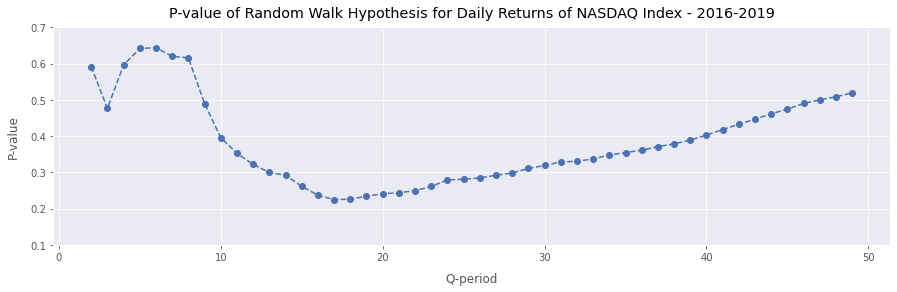

In [118]:
plt.figure()
plt.plot(test['q'], test['P-value'], '--o')
plt.title('P-value of Random Walk Hypothesis for Daily Returns of NASDAQ Index - 2016-2019')
plt.xlabel('Q-period')
plt.ylabel('P-value')
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.show()

We can see that, for the analyzed period of log-values of the NASDAQ Index, the RW3 hypothesis cannot be rejected. This indicates that during this period, the market was quite competitive and efficient.

### 2nd Period: start of 2019 until September 2021

In [119]:
# get log differences of series
log_diff2 = series2['log_value'].diff().dropna().reset_index(drop=True)

In [124]:
test = {
    'q': np.arange(2,50,1),
    'VR': [],
    'T-statistic': [],
    'P-value': [],
}

for q in test['q']:
    vr, phi, p_value = test_RW3(log_diff2, q)
    test['VR'].append(vr)
    test['T-statistic'].append(phi)
    test['P-value'].append(p_value)

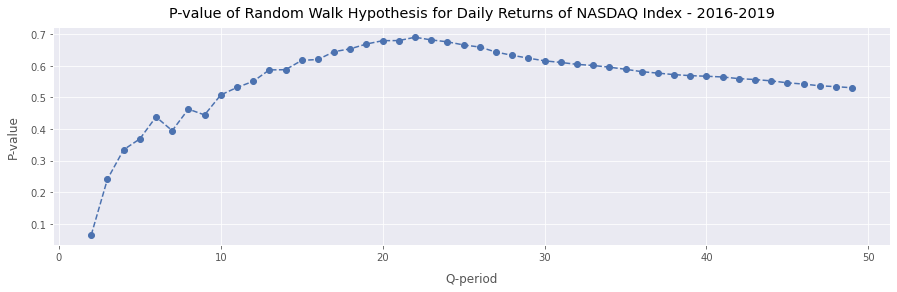

In [125]:
plt.figure()
plt.plot(test['q'], test['P-value'], '--o')
plt.title('P-value of Random Walk Hypothesis for Daily Returns of NASDAQ Index - 2016-2019')
plt.xlabel('Q-period')
plt.ylabel('P-value')
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.show()

When analyzing this second period, we see that the Random Walk hypothesis can be rejected at the 10% confidence level when using q=2. This might be due to the fact that this period of the NASDAQ Index showed large variations and may have risen artificially, which negates the efficient markets hypothesis.